<a href="https://colab.research.google.com/github/MarioAvolio/102-Category-Flower-Dataset-with-Keras/blob/main/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Analysis
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

102 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 102 different categories. 
The images were acquired by searching the web and taking pictures. There are a
minimum of 40 images for each category.

The images are contained in the file 102flowers.tgz and the image labels in
imagelabels.mat.

We provide 4 distance matrices. D_hsv, D_hog, D_siftint, D_siftbdy. These
are the chi^2 distance matrices used in the publication below.

The database was used in:

Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.

Datasplit
------------------------------------------------
The datasplits used in this paper are specified in setid.mat.

The results in the paper are produced on a 103 category database. The two
categories labeled Petunia have since been merged since they are the same.
There is a training file (trnid), a validation file (valid)
and a testfile (tstid). 

Segmentation Images
------------------------------------------------
We provide the segmentations for the images in the file 102segmentations.tgz

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmenation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback07.(pdf,ps.gz).
.

History
-----------------------------------------------
version 1.1 - Two petunia categories merged into one. 

# Requirements

In [11]:
from google.colab import drive
from os import listdir
from os.path import isfile, join
from PIL import Image
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os.path
from os import path
from sklearn.decomposition import PCA
import pandas as pd
import tarfile
import scipy
from scipy import io
import PIL

In [2]:
drive.mount('/content/gdrive', force_remount=True)
PATH_PROJ = "/content/gdrive/MyDrive/AML-proj/" 
if not path.exists(PATH_PROJ):
    PATH_PROJ = "/content/gdrive/Shareddrives/AML-proj/"  # TODO: check if it is correct!

PATH_EXTRACT = PATH_PROJ + 'ExtractData/'
PATH_JPG = PATH_PROJ + 'jpg/'

NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

Mounted at /content/gdrive


# Functions

In [12]:
def execute_pca_on_imgs(img, show=False):
  # Splitting the image in R,G,B arrays.
  blue,green,red = cv2.split(img) 
  #it will split the original image into Blue, Green and Red arrays.

  #initialize PCA with at least 95% variance
  pca = PCA(0.95)
  
  #Applying to red channel and then applying inverse transform to transformed array.
  red_transformed = pca.fit_transform(red)
  red_inverted = pca.inverse_transform(red_transformed)
  
  #Applying to Green channel and then applying inverse transform to transformed array.
  green_transformed = pca.fit_transform(green)
  green_inverted = pca.inverse_transform(green_transformed)
  
  #Applying to Blue channel and then applying inverse transform to transformed array.
  blue_transformed = pca.fit_transform(blue)
  blue_inverted = pca.inverse_transform(blue_transformed)

  # compressiong
  img_compressed = (np.dstack((red_inverted, green_inverted, blue_inverted))).astype(np.uint8)
  #viewing the compressed image
  if show: 
    plt.imshow(img_compressed)

  return img_compressed
    

def execute_pca_on_imgs_set(data):
  for i in range(len(data)):
    data[i] = execute_pca_on_imgs(data[i])
    

def processing_set(dataset, images, labels, size=224, return_pca=False):
  x, y = [], []
  for num_img in dataset:
    # print(f"linking {num_img} to {images[num_img - 1]}")
    path = PATH_JPG + images[num_img - 1]
    im=cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,(size,size))
    x.append(im)
    y.append(labels[num_img - 1])
  
  if return_pca:
    return execute_pca_on_imgs_set(x), np.asarray(y) 
  else:
    return np.asarray(x), np.asarray(y)





## Plot Functions

In [15]:
def count_box_plot(unique_elem_dict, title, label):

  list_value=np.array(list(unique_elem_dict.values()))
  fig, ax = plt.subplots()

  # Save the chart so we can loop through the bars below.
  bars = ax.bar(range(len(unique_elem_dict)), list_value, align='center', tick_label=list(unique_elem_dict.keys()))

  # Axis formatting.
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)


  # Add labels and a title.
  ax.set_xlabel('Model type', labelpad=15, color='#333333')
  ax.set_ylabel(label, labelpad=15, color='#333333')
  ax.set_title(title, pad=15, color='#333333',
              weight='bold')

  plt.show()


def plot_figure(df, path_figure = PATH_JPG):
  plt.figure(figsize=(12,8))
  random_image = df.sample(n=9)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(3,3, index+1)
      plt.imshow(im)
      plt.title('Class: '+ NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()

# Data

In [5]:
df = pd.DataFrame()
df['Id'] = sorted(os.listdir(PATH_JPG))
df['Category'] = scipy.io.loadmat(PATH_PROJ + 'imagelabels.mat')['labels'][0] - 1 
df['Category'] = df['Category'].astype(str)
df.head(5)

,Id,Category
0,image_00001.jpg,76
1,image_00002.jpg,76
2,image_00003.jpg,76
3,image_00004.jpg,76
4,image_00005.jpg,76


In [6]:
df['Category'].nunique()

102

In [7]:
counts = df['Category'].value_counts()
idx = counts.index.tolist()

count_numbers_of_flowers_by_name = {}
for label_number in idx:
  x = counts[label_number]
  count_numbers_of_flowers_by_name[NAMES[int(label_number)]] = x
  # print(f"numbers of {NAMES[int(label_number)]} = {x}")

print(count_numbers_of_flowers_by_name)

{'petunia': 258, 'passion flower': 251, 'wallflower': 196, 'water lily': 194, 'watercress': 184, 'rose': 171, 'frangipani': 166, 'foxglove': 162, 'cyclamen': 154, 'lotus': 137, 'hibiscus': 131, 'sword lily': 130, 'bougainvillea': 128, 'barbeton daisy': 127, 'thorn apple': 120, 'geranium': 114, 'clematis': 112, 'bishop of llandaff': 109, 'pink-yellow dahlia?': 109, 'cape flower': 108, 'morning glory': 107, 'anthurium': 105, 'californian poppy': 102, 'azalea': 96, 'primula': 93, 'poinsettia': 93, 'common dandelion': 92, 'fritillary': 91, 'camellia': 91, 'snapdragon': 87, "colt's foot": 87, 'columbine': 86, 'bird of paradise': 85, 'sweet william': 85, 'purple coneflower': 85, 'wild pansy': 85, 'mexican petunia': 82, 'peruvian lily': 82, 'canna lily': 82, 'artichoke': 78, 'gazania': 78, 'hippeastrum': 76, 'ruby-lipped cattleya': 75, 'pelargonium': 71, 'buttercup': 71, 'orange dahlia': 67, 'gaura': 67, 'marigold': 67, 'lenten rose': 67, 'stemless gentian': 66, 'mallow': 66, 'bee balm': 66, 

In [8]:
key_max = max(count_numbers_of_flowers_by_name.keys(), key=(lambda k: count_numbers_of_flowers_by_name[k]))
key_min = min(count_numbers_of_flowers_by_name.keys(), key=(lambda k: count_numbers_of_flowers_by_name[k]))


print(f"Maximum Value: {key_max} with {count_numbers_of_flowers_by_name[key_max]} samples")
print(f"Minimum Value: {key_min} with {count_numbers_of_flowers_by_name[key_min]} samples")

Maximum Value: petunia with 258 samples
Minimum Value: canterbury bells with 40 samples


In [9]:
print(os.listdir(PATH_JPG)[:5])

['image_07211.jpg', 'image_07255.jpg', 'image_07213.jpg', 'image_07184.jpg', 'image_07262.jpg']


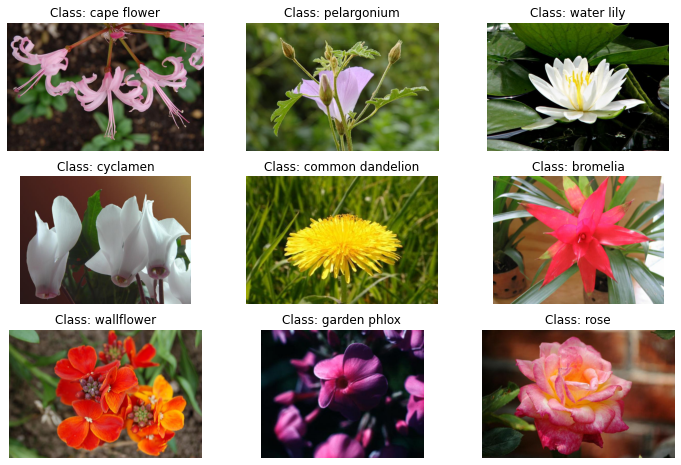

In [16]:
plot_figure(df)

## Split

In [10]:
from sklearn.model_selection import train_test_split
#split the data and prepare for a general ML training 

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle = True, stratify = None)

X_train.shape, X_test.shape

NameError: ignored

In [ ]:
X_train, Y_train = processing_set(X_train, images, labels, return_pca=True)
# X_val, y_val = processing_set(val_set, images, labels)#, return_pca=True)
X_test, Y_test = processing_set(X_test, images, labels, return_pca=True)




In [ ]:
plt.imshow(X_train[0], interpolation='nearest')
plt.show()
Y_train[0]

## Hot Encoding